In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding   生成位置编码
# 3.2 create mask. (a. padding, b. decoder)  一个是padding损失mask 一个是decoder不能看到后面词的mask
# 3.3 scaled_dot_product_attention  缩放点积注意力
# 4. builds model
# 4.1 MultiheadAttention
# 4.2 EncoderLayer   一个block
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

examples, info = tfds.load('ted_hrlr_translate/pt_to_en',  # TED演讲。。。
                           with_info = True,
                           as_supervised = True)  # 基于subword的数据集

train_examples, val_examples = examples['train'], examples['validation']
# print(info)

for pt,en in train_examples.take(5):  # 我们看到这个数据葡萄牙语的特殊字符已经被转义，并且标点符号前后都用了空格
    print(pt.numpy())  # 因为已经是dataset的格式所以看数据需要转化为numpy
    print(en.numpy())
    print()

2.3.0
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.0
tensorflow.keras 2.4.0
b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'



In [2]:
# 构建subword数据集
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((
    en.numpy() for pt,en in train_examples),
    target_vocab_size = 2**13)  # 8192
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((
    pt.numpy() for pt,en in train_examples),
    target_vocab_size = 2**13)

In [3]:
sample_string = "Transformer is awesome."
tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))
assert origin_string == sample_string
for token in tokenized_string:  # 加了个引号就知道空格去哪了，跟在单词后面
    print('{}-->"{}"'.format(token,en_tokenizer.decode([token])))  # decode必须传列表



Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915-->"T"
1248-->"ran"
7946-->"s"
7194-->"former "
13-->"is "
2799-->"awesome"
7877-->"."


In [4]:
# 创建数据集
buffer_szie = 20000
batch_szie = 64
max_length = 40

def encode_to_subword(pt_sentence,en_sentence):
    # 和seq2seq + attention 一样，这里为句子的前后都加上特殊字符的ID
    # 因为词表是 vocab size - 1
    pt_sentence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(pt_sentence.numpy()) \
                  + [pt_tokenizer.vocab_size + 1]
    en_sentence =  [en_tokenizer.vocab_size] + en_tokenizer.encode(en_sentence.numpy()) \
                   + [en_tokenizer.vocab_size + 1]
    return pt_sentence,en_sentence


def filter_by_max_length(pt,en):  # 因为是tensor的计算所以这边同TF的api，将小于max-length句子过滤掉
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence,en_sentence):
    # 因为tf的dataset的map函数不可以接受python函数，所以需要把函数给用pyfunc进行封装
    # 这个py_function 接受原函数的输入，规定原函数的返回结果的类型
    return tf.py_function(encode_to_subword,[pt_sentence,en_sentence],[tf.int64,tf.int64])

train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(buffer_szie).padded_batch(
    batch_szie,padded_shapes = ([-1],[-1]))  # 这两个-1表示将数据都pad到本身维度的最大值

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length)
valid_dataset = valid_dataset.shuffle(buffer_szie).padded_batch(
    batch_szie,padded_shapes = ([-1],[-1]))



In [5]:
for pt_batch,en_batch in valid_dataset.take(5):
    print(pt_batch.shape,en_batch.shape)

(64, 38) (64, 40)
(64, 37) (64, 38)
(64, 39) (64, 37)
(64, 36) (64, 38)
(64, 38) (64, 40)


In [6]:
# 位置编码
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

# pos.shape: [sentence_length, 1]
# i.shape  : [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos,i,d_model): # pos为在句子中的位置，i为embedding的位置
    # 先把i整除2 再乘以2 就区分了奇偶，看公式，奇数计算要的是比奇数小1的偶数
    # 相乘之后就i得到了sentence 相对于embedding的每一个位置的角度值
    angle_rates = 1 / np.power(10000,2 * (i // 2) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length,d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:,np.newaxis],  # 看上面注释。需要把这两个给扩展成矩阵，新增维度
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    # sines.shape = [sentence_length,d_model / 2]
    # cosines.shape  = [sentence_length,d_model / 2]
    sines = np.sin(angle_rads[:,0::2])  # 从零开始每隔一个取一个就是偶数
    cosines = np.cos(angle_rads[:,1::2])  # 奇数
    # 拼接起来上面两个  shape = [sentence_length,d_model]
    positional_embedding = np.concatenate([sines,cosines],axis = -1)
    # 为了使用方便还需要最前面加一个维度  shape = [1,sentence_length,d_model]
    positional_embedding = positional_embedding[np.newaxis,...]

    return tf.cast(positional_embedding,dtype = tf.float32)


position_embedding = get_position_embedding(50,512)
print(position_embedding.shape)


(1, 50, 512)


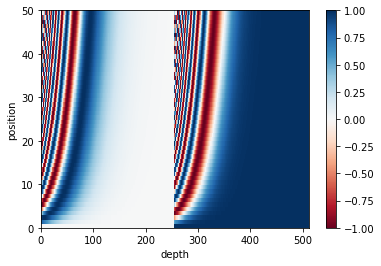

In [7]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0],cmap = 'RdBu')
    plt.xlabel('depth')
    plt.xlim((0,512))
    plt.ylabel('position')
    plt.colorbar()
    plt.show()

plot_position_embedding(position_embedding)

In [8]:
# 如何生成mask
# 1、padding的mask   没必要对padding的部分做self attention
# 2、look ahead mask  decoder只能和之前词语发生attention  而不能和之后的词语发生attention
def create_padding_mask(batch_data):  # batch-data 的shape是 （batch-size，seq-len）
    # 是零的最后就是1 不是零的是0，和seq2seq不一样，那里面取反了   1是忽略
    padding_mask  = tf.cast(tf.math.equal(batch_data,0),dtype = tf.float32)
    # 为了方便和attention的维度方便计算，添加一些维度
    # return.shape = (batch-size,1,1,seq-len)
    return padding_mask[:,np.newaxis,np.newaxis,:]

x = tf.constant([[7,6,0,0,1],[1,2,3,0,0],[0,0,0,4,5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [9]:
# attention_weights.shape: [3,3]
# [[1, 2, 3],           [a11,a12,a13]
#  [4, 5, 3],           [a21,a22,a23]
#  [7, 8, 9]]           [a31,a32,a33]
# 上面矩阵是什么意思，就是1代表第一个词和自己的attention，12就是1和2的，依次类推
# 那么，下标11 22 33 就是极限，自己对自己的，而12 就是超出，也就是看到后面的词的，也就是要mask掉，置零
# 那么最后就是 [a11,0,0]
#             [a21,a22,0]
#             [a31,a32,a33]         所以我们发现，就是要一个上三角矩阵，上三角mask，而下三角保留
def create_look_ahead_mask(size):
    # 这个函数就是得到下三角矩阵，num_lower=-1表示保留下三角，num_upper=0表示上三角置零
    # 实际要和上面的匹配，上面的mask是 1是被忽略，所以我这边1减去，上三角就为1
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)),num_lower = -1,num_upper = 0)
    # 一般传进来的size 就是seq-len  所以最后mask的shape就是 （seq-len，seq-len）
    return mask


create_look_ahead_mask(3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [10]:
# 缩放点积注意力的实现
def scaled_dot_product_attention(q,k,v,mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)   q k 做矩阵乘法，所以最后一个维度depth是相等的，K转置
    - v: shape == (..., seq_len_v, depth_v)   k v 是一一对应的，所以seq_len_k和seq_len_v也是相等的
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)  q k 做完矩阵乘法之后，做mask
    Returns:
    - output: weighted sum  做完注意力和v相乘得到的加权平均的和
    - attention_weights: weights of attention   可视化
    """

    # matmul_qk.shape = (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q,k,transpose_b = True)  # 就是让第二个矩阵转置

    # k和q的最后一个维度是相同的，原理去看我的笔记
    dk = tf.cast(tf.shape(k)[-1],dtype = tf.float32)  # dk就k的最后一维度，因为要做开方所以转化类型
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        # 加上mask，加上一个特别小的数  要mask的为1，不要mask的为0不受影响，一乘就出来结果了。为什么是加
        # 因为scaled_attention_logits需要经过softmax才得到权重，加上-10^9之后，使得在softmax时候趋近于0
        # 以达到mask的效果
        scaled_attention_logits += (mask * -1e9)

    # 达到一种权重的效果   attention_weight.shape = (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits,axis = -1)  # 在sqe-len这个维度进行softmax

    # output.shape = (...，seq-len-q,depth-v)
    output = tf.matmul(attention_weights,v)  # 因为attention_weights最后一个维度和v的seq_len_v相等，可以乘

    return output,attention_weights

def print_scaled_dot_product_attention(q,k,v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)

# 你有一个问题Q，然后去搜索引擎里面搜，搜索引擎里面有好多文章，每个文章V有一个能代表其正文内容的标题K，
# 然后搜索引擎用你的问题Q和那些文章V的标题K进行一个匹配，看看相关度（QK --->attention值），
# 然后你想用这些检索到的不同相关度的文章V来表示你的问题，就用这些相关度将检索的文章V做一个加权和，
# 那么你就得到了一个新的Q'，这个Q'融合了相关性强的文章V更多信息，而融合了相关性弱的文章V较少的信息。
# 这就是注意力机制，注意力度不同，重点关注（权值大）与你想要的东西相关性强的部分，稍微关注（权值小）相关性弱的部分。

In [11]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype = tf.float32)  # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype = tf.float32)  # (1, 3)   注意维度之间的相等
# 这人说，q1是0，10，0 所以只有和k的第二行才有值，所以希望attention weights 是第一列0100

np.set_printoptions(suppress = True)  # 结果四舍五入
print_scaled_dot_product_attention(temp_q1,temp_k,temp_v)
# 通过结果就可以发现，这里q和k只有第二行有attention，也就是权重，所以取出的v中也就只有第二行10，0



Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [12]:
temp_q2 = tf.constant([[0, 0, 10]], dtype = tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)
# 这边的结果就是0，0，10 和k最后两行有attention 所以取出的v的最后两行，并且attention都是0.5，所以会变求和，然后一半

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [13]:
temp_q3 = tf.constant([[10, 10, 0]], dtype = tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)  # 同上面，会在第一第二行平分

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [14]:
# 拼起来q1，q2，q3
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype = tf.float32)  # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)  # 看到结果就是上面 刚才三个组合，results和attention
# 都是


Attention weights are:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [15]:
# 多头注意力，采用子类api来实现
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    在里理论里面，就是把x定下来去做乘法，实际中不同场景这个初始值不一定是一样的，对于self-attention是一样的
    实战中:
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0

    实战中技巧： 实际中从q 到 q0.q1.q2..... 是需要乘以多个wq0  wq1  .... 下面是技巧 大矩阵 split，k，v 类似
    q -> Wq -> Q -> split -> q0, q1, q2...                  使得运算更加密集快速
    """
    def __init__(self,d_model,num_heads):
        # 模型的维度，注意力多头的头数
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0  # 因为d-model是被分成 num-heads个的，确保整除
        # d_model 就是 乘wq的输出，经过split分解成很多个，每一个头的depth就是
        self.depth = self.d_model // self.num_heads
        # 定义三个全连接，wq wk wv
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)

        # 许多个多头注意力拼接的全连接操作，迷，已经reshape合并了，怎么还全连接合并？
        self.dense = keras.layers.Dense(self.d_model)

    def split_heads(self,x,batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))  # 就是把一开始的d-model分成两个
        # 在做维度重排列   只需要交换seq_len  num_heads
        return tf.transpose(x,perm = [0,2,1,3])


    def call(self,q,k,v,mask):
        batch_size = tf.shape(q)[0]
        # 在这之前qkv是什么，可以认为是经过embedding的，所以shape为（batch_size,seq_len,embedding-dim）
        # 也可以认为就是中间层的结果，那么最后一个维度就是输出的大小，依据模型而定
        # 分别让q，k，v经过三个全连接然后得到大矩阵
        q = self.WQ(q)  # q.shape = (batch_size,sqe_len_q,d_model)
        k = self.WK(k)  # k.shape = (batch_size,sqe_len_k,d_model)
        v = self.WV(v)  # v.shape = (batch_size,sqe_len_v,d_model)
        # 这边由于一开始qkv的长度不一定是一样长的，所以第二个维度也不是一样的，但是得保证k，v的长度是一样的
        # 不懂就去看那个缩放点积注意力的函数,而且 qk的depth也应该是一样的

        q = self.split_heads(q,batch_size)  # q.shape = (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k,batch_size)  # k.shape = (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v,batch_size)  # v.shape = (batch_size, num_heads, seq_len_v, depth)

        # 这边就得到的QKV三个矩阵了，就可以计算scaled_dot_product_attention了
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs,attention_weights = scaled_dot_product_attention(q,k,v,mask)

        # 下面就是多头的拼接，由于信息都在num_heads 和 depth维度上，所以要先把num_heads, seq_len_q调换位置
        # 然后再把最后两个维度给拼接起来
        # scaled_attention_outputs.shape = (batch_size,seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(scaled_attention_outputs,perm = [0,2,1,3])
        # 这边这个合并，怎么是乘起来。哦哦哦好像是乘起来........num_heads, depth合并
        concat_attention = tf.reshape(scaled_attention_outputs,(batch_size,-1,self.d_model))
        # concat_attention.shape: (batch_size, seq_len_q, d_model)

        # 总结一下，这里用了两次维度交换，为什么要用，变换完了又变回去呢？
        # 是因为头与头之间的scaled_dot_product_attention 是分开来计算的，而且在这个计算的函数里面
        # 计算attention使用了后两维进行计算，所以在split里面要先交换维度让seq_len, depth在一起
        # 然后再换回来

        # 多个头的注意力合并后做，全连接
        output = self.dense(concat_attention)  # output.shape : (batch_size, seq_len_q, d_model)

        return output,attention_weights


temp_mha = MultiHeadAttention(d_model = 512,num_heads = 8)
y = tf.random.uniform((1,60,256))  # 随机初始化(batch，seq-len，dim)
# y当作qkv三个
output,atten = temp_mha(y,y,y,mask = None)
print(output.shape)
print(atten.shape)



(1, 60, 512)
(1, 8, 60, 60)


In [16]:
# feed forward 再decoder 和encoder都用到
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation = 'relu'),
        keras.layers.Dense(d_model)
    ])


sample_ffn = feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)


(64, 50, 512)


In [17]:
class EncoderLayer(keras.layers.Layer):
    # 这个encoder 做什么，  实际上还加了dropout
    # 输入x -> self attention -> add & normalize & dropout-> feed_forward -> add & normalize & dropout
    # 这也是为什么call函数有training  和 初始化右rate的原因
    def __init__(self,d_model,num_heads,dff,rate = 0.1):
        # d_model -> self attention + FC | num_heads -> self attention | dff -> FC
        # rate is the rate of dropout
        super(EncoderLayer,self).__init__()
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = feed_forward_network(d_model,dff)
        # 做add and norm  为什么用LayerNormalization
        # 以上两点缺陷，其实都是由于batch数量过少引起的，若模型没有使用RNN，可以通过增加batch大小来解决。
        # 使用RNN时，可以截断时间步，使得各个时间步的样本数量相同，但这样抛弃了许多信息，并不建议使用。
        # 当没有截断时间步时，RNN靠后时间步样本少的问题无法解决，因此无法使用BN。
        # 针对batch数过少引起问题，提出了Layer Normalization加以解决。
        # BN是不同样本同一通道做归一化，而LN则是同一样本不同的通道归一化
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)


    def call(self,x,training,encoder_padding_mask):
        # x shape = （batch_size,seq_len,dim = d_model）  或者是上一层输出的dim
        attn_output,_ = self.mha(x,x,x,encoder_padding_mask)  # 不用attention weight  这里attn_output shape为 换行
        # (batch_size, seq_len_q, d_model)    经过dropout  shape不变
        attn_output = self.dropout1(attn_output,training = training)  # 是不是在训练，测试就没必要dropout
        out1 = self.layer_norm1(x + attn_output)  #  + 就是残差连接  这边有个约束，就是x的shape和attention out 相同
        # 那么也就是dim = d_model  也就是在层的输出或者是embedding时候 得注意这两个维度相等
        # 所以我再初始化的时候，用的MultiHeadAttention feed_forward_network输出都是d-model
        # out1.shape = (batch_size,seq_len,d_model)

        ffn_output = self.ffn(out1)  # shape = (batch_size,seq_len,d_model)
        ffn_output = self.dropout2(ffn_output,training = training)
        out2 = self.layer_norm2(out1 + ffn_output)  # 看维度，能加
        # out2.shape = (batch_size,seq_len,d_model)
        # 因为残差连接，所以许多的shape都是一样的
        return out2

sample_encoder_layer = EncoderLayer(512,8,2048)
sample_input = tf.random.uniform((64,50,512))  # 这两512就是必须相等的dim = d_model
sample_output = sample_encoder_layer(sample_input,False,None)
print(sample_output.shape)



(64, 50, 512)


In [18]:
# decoder layer由于有decoder和encoder之间的attention，所以有多一个层次。
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self,d_model,num_heads,dff,rate = 0.1):
        super(DecoderLayer,self).__init__()
        self.mha1 = MultiHeadAttention(d_model,num_heads)  # 给输入做self attention的
        self.mha2 = MultiHeadAttention(d_model,num_heads)  # 给encoder和decoder之间做attention

        self.ffn = feed_forward_network(d_model,dff)
        # 因为上面有三个层，所以有三个layer norm 和三个dropout
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)


    def call(self,x,encoding_outputs,training,decoder_mask, encoder_decoder_padding_mask):
        # look_ahead_mask是decoder在解码的时，不能看到后面的单词
        # 而padding_mask是encoder和decoder之间的mask，encoder做padding部分是无效的
        # x.shape = (batch_size,target_seq_len,d_model)   目标语言的长度。需要做残差连接
        # encoding_outputs.shape = (batch_size,input_seq_len,d_model)
        # 两个d_model 虽然名字一样但是实际上一个是encoder里面的，一个是decoder里面的，但值一样的
        attn1,attn_weights1 = self.mha1(x,x,x,decoder_mask)  # attn1 (batch_size,target_seq_len,d_model)
        attn1 = self.dropout1(attn1,training = training)
        out1 = self.layer_norm1(x + attn1)  # (batch_size,target_seq_len,d_model)

        # attn2,out2 : (batch_size,target_seq_len,d_model)
        attn2,attn_weights2 = self.mha2(out1,encoding_outputs,encoding_outputs,encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2,training = training)
        out2 = self.layer_norm2(out1 + attn2)

        # ffn_output,out3 : (batch_size,target_seq_len,d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training = training)
        out3 = self.layer_norm3(ffn_output + out2)

        return out3,attn_weights1,attn_weights2

sample_decoder_layer = DecoderLayer(512,8,2048)
sample_decoder_input = tf.random.uniform((64,60,512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)  # (64, 60, 512)
print(sample_decoder_attn_weights1.shape)  # (64, 8, 60, 60)
print(sample_decoder_attn_weights2.shape)  # (64, 8, 60, 50)  因为sample_output是 50
# 所以attention1 是self attention  attention2  是两者之间的


(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [19]:
# 构建model  堆叠layer
class EncoderModel(keras.layers.Layer):
    def __init__(self,num_layers,input_vocab_size,max_length,
                 d_model,num_heads,dff,rate = 0.1):
        # num_layer就是我有几个encoder layer    input_vocab_size 是由于需要做embedding 词表大小
        # max length是做位置编码需要的参数 后面的参数就是encoder layer需要的参数
        super(EncoderModel,self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.max_length = max_length

        # 不仅有词语的embedding还得有位置的embedding
        self.embedding = keras.layers.Embedding(input_vocab_size,self.d_model)
        self.position_embedding = get_position_embedding(max_length,self.d_model)
        # position_embedding.shape = (1,max_length,d_model)

        # 在获得最后的Embedding做一个dropout
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [EncoderLayer(self.d_model,num_heads,dff,rate)
                               for _ in range(num_layers)]


    def call(self,x,training,encoder_padding_mask):
        # x.shape = (batch_size,sqe_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        x = self.embedding(x)  # 给x做embedding  shape = (batch_size,input_seq_len,d_model)

        # 让经过embedding的x和position_embedding进行加法，看我画的原理图
        # 因为x的shape是(batch_size,input_seq_len,d_model) 想要和position_embedding加法，必须要
        # 把position_embedding的前 input_seq_len取出来才能加 再加之前还需要进行缩放
        # 这里是因为一开始x被embedding初始化后从属于0-1的均匀分布取值的，而乘了这个根号d model后
        # 使得值属于（0- d_model） 缩放完后了就可以让x和position_embedding相加时候x本身起的作用大一点
        x *= tf.math.sqrt(tf.cast(self.d_model,dtype = tf.float32))  # 初始化trick
        # 其实在这里虽然第二个维度进行了切片但是第一个维度还没有对齐，TF会默认给position_embedding进行复制
        x += self.position_embedding[:,:input_seq_len,:]  # 所以相当于x的每一个样本都加上position_embedding

        x = self.dropout(x,training)
        for i in range(self.num_layers):  # 然后就是多个encoder_layers的串联
            x = self.encoder_layers[i](x,training,encoder_padding_mask)

        # x.shape = (batch_size,input_seq_len,d_model) 不会发生变化
        return x


sample_encoder_model = EncoderModel(2,8500,max_length,512,8,2048)
sample_encoder_model_input = tf.random.uniform((64,37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input,False,
                                                   encoder_padding_mask = None)
print(sample_encoder_model_output.shape)
# (batch_size,input_seq_len,d_model)



(64, 37, 512)


In [20]:
class DecoderModel(keras.layers.Layer):
    def __init__(self,num_layers,target_vocab_size,max_length,d_model,
                 num_heads,dff,rate = 0.1):
        super(DecoderModel,self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.max_length = max_length
         # 不仅有词语的embedding还得有位置的embedding
        self.embedding = keras.layers.Embedding(target_vocab_size,self.d_model)
        self.position_embedding = get_position_embedding(max_length,self.d_model)
        self.dropout = keras.layers.Dropout(rate)

        self.decoder_layers = [DecoderLayer(self.d_model,num_heads,dff,rate)
                               for _ in range(self.num_layers)]


    def call(self,x,encoding_outputs,training,decoder_mask, encoder_decoder_padding_mask):
        # x.shape = (batch_size,out_seq_len)
        out_seq_len = tf.shape(x)[1]
        # 不能直接用assert 小于 因为会认为用tensor变量当成了bool使用，要使用TF的API
        tf.debugging.assert_less_equal(
            out_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")

        attention_weights = {}  # 都是由decoder_layers返回回来的
        x = self.embedding(x)  # (batch_size,out_seq_len,d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x += self.position_embedding[:,:out_seq_len,:]

        x = self.dropout(x,training = training)

        # decoer layers 串联
        for i in range(self.num_layers):
            x,att1,att2 = self.decoder_layers[i](x,encoding_outputs,training,
                                                 decoder_mask, encoder_decoder_padding_mask)
            attention_weights['decoder_layer{}_att1'.format(i + 1)] = att1
            attention_weights['decoder_layer{}_att2'.format(i + 1)] = att2
        # x.shape = (batch_size,out_seq_len,d_model)  也和encoder一样不发生变化

        return x,attention_weights


sample_decoder_model = DecoderModel(2,8000,max_length,512,8,2048)
sample_decoder_model_input = tf.random.uniform((64,35))
sample_decoder_model_output,sample_decoder_model_att = sample_decoder_model(
    sample_decoder_model_input,sample_encoder_model_output,training = False,
    decoder_mask = None,
    encoder_decoder_padding_mask = None
)
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)
# 从这边可以看出来，这里边attention有四个，每两个是一组，分别是自己的attention和encoder和decoder之间的
# 一个35 一个37



(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [21]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        self.encoder_model = EncoderModel(num_layers,input_vocab_size,
                                          max_length,d_model,num_heads,dff,rate)
        self.decoder_model = DecoderModel(num_layers,target_vocab_size,
                                          max_length,d_model,num_heads,dff,rate)
        # final_layer接受decoder_model的输出，映射到词表大小的空间
        self.final_layer = keras.layers.Dense(target_vocab_size)


    def call(self,inp,tar,training,encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape = (batch_size,input_seq_len,d_model)
        encoding_outputs = self.encoder_model(inp,training,encoder_padding_mask)
        decoding_outputs,attention_weights = self.decoder_model(tar,encoding_outputs,training,
                                                                decoder_mask, encoder_decoder_padding_mask)
        # decoding_outputs.shape = (batch_size,out_seq_len,d_model)

        # predictions.shape = (batch_size,out_seq_len,target_vocab_size)
        predictions = self.final_layer(decoding_outputs)

        return predictions,attention_weights

sample_transformer = Transformer(2,8500,8000,max_length,512,8,2048,0.1)
# sample_transformer.summary()
temp_input = tf.random.uniform((64,26))
temp_target = tf.random.uniform((64,31))
predictions,attention_weights = sample_transformer(temp_input,temp_target,training = False,
                                                   encoder_padding_mask = None,
                                                   decoder_mask = None,
                                                   encoder_decoder_padding_mask = None)
print(predictions.shape)
for key in attention_weights:
    print(attention_weights[key].shape)





(64, 31, 8000)
(64, 8, 31, 31)
(64, 8, 31, 26)
(64, 8, 31, 31)
(64, 8, 31, 26)


In [22]:
# training:
# 1. initializes model.
# 2. define loss, optimizer, learning_rate schedule
# 3. train_step
# 4. train process

In [23]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2  # 加了startID 和endID
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

In [24]:
transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

In [25]:
# 自定义学习率
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),step_num * warm_up_steps **(-1.5))
# 这个曲线就是先增加再减小
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()

        self.d_model = tf.cast(d_model,tf.float32)
        self.warmup_step = warmup_steps


    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)  # 根号x 分之一
        arg2 = step * (self.warmup_step ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        return arg3 * tf.math.minimum(arg1,arg2)

# 这边有个参数d model  这参数就是模型的大小，当这个参数越大的时候，那么模型就比较大，从而使得我的arg3 这个参数小
# 那么就可以让lr比较小，因为越大的模型越难以拟合需要小一点的lr
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,beta_1 = 0.9,
                                  beta_2 = 0.98,epsilon = 1e-9)
checkpoint_dir = './training_checkpoints_big_data'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(Transformer = transformer)


Text(0.5, 0, 'Train step')

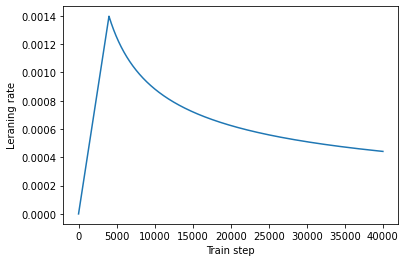

In [26]:
# 图示lr
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype = tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [27]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,  # 再transformer模型中最后没有使用激活函数
    reduction = 'none'   # 需要处理mask 所以不能用这个自带的
)

def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))  # 先判断是不是0，是0就是true，取反就是false
    loss_ = loss_object(real,pred)
    mask = tf.cast(mask,dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [28]:
def create_masks(inp,tar):
    # inp 是原语言的句子，tar是目标语言的句子，在机器翻译中
    """
    Encoder:
      - encoder_padding_mask (works on self attention of EncoderLayer)
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)  之后的词还没被预测出来
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      这个attention在DecoderLayer第二个attention层上做的
      上面需要在二者之间做attention decoer的隐含状态和encoder的输出做的attention
      encoder有padding  所以那些padding是不需要的做attention的 需要过滤
      - decoder_padding_mask (self attention of DecoderLayer)
    look_ahead_mask 和 decoder_padding_mask 都是在 DecoderLayer第一个attention 并且是自缩放点积注意力
    而在MultiHeadAttention类中的scaled_dot_product_attention 函数只有一个mask的输入，所以需要把两个mask合并
    ‘与’  操作  只要在任何词在二者一个位置上，都认为被mask了
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    # 其实encoder_decoder_padding_mask也是咋input上的mask 因为就是encoder 的padding
    # 但是还是分开是为了理解而已
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # 为啥是一维度 seq-len
    # look_ahead_mask创建的mask是一个正方形，正方形的边长就是句子的长度 里面的值上三角是1下三角和对角线都0
    decoder_padding_mask = create_padding_mask(tar)
    # look_ahead_mask & decoder_padding_mask 作用在同一层次，需要合并
    # 与操作，因为都是01，被mask的部分是1，不被mask的部分是0  我觉得可以这么理解最大值，如果任何一个是1
    # 也就是需要被mask 那么就是1 ，如果两个都是0就不需要mask 就是0 所以是maximun
    decoder_mask = tf.maximum(decoder_padding_mask,look_ahead_mask)
    # print(encoder_padding_mask.shape)
    # print(encoder_decoder_padding_mask.shape)
    # print(look_ahead_mask.shape)
    # print(decoder_padding_mask.shape)
    # print(decoder_mask.shape)
    # (64, 40)         input
    # (64, 38)         target
    # (64, 1, 1, 40)   input 的mask
    # (64, 1, 1, 40)   差不多
    # (38, 38)         方阵 上下三角矩阵
    # (64, 1, 1, 38)   target的mask
    # (64, 1, 38, 38)  为什么是这个维度：因为（38，38）维度不够，所以先复制成（64，1，38，38）
    # 此时(64, 1, 1, 38)的维度也不够了，那么会在自己最后一维38 复制38分让倒数第二维度成38 就可加了
    # 这时候的decoder_mask就兼具两种mask信息 不关注padding也不能看到后面的词
    return encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask


In [29]:
temp_inp,temp_tar = iter(train_dataset.take(1)).next()

In [30]:
# 从train dataset 里面取数据需要填充buffer size的缓冲区，因为要做shuffle，所以上述代码需要一定时间
print(temp_inp.shape)
print(temp_tar.shape)

(64, 39)
(64, 40)


In [31]:
create_masks(temp_inp,temp_tar)

(<tf.Tensor: shape=(64, 1, 1, 39), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

In [32]:
train_loss = keras.metrics.Mean(name = "train_loss")
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")
# 可累积的观测参数
# 但这个精度并不是机器翻译那个评价指标，只是直观的看一下结果
@tf.function
def train_step(inp,tar):
    # inp 就是直接输入给encoder 而decoder是需要输入上一个词预测下一个词，所以 tar需要切分
    tar_inp = tar[:,:-1]  # 从第一个到倒数第二个  输入给decoder预测是不是tar_real
    tar_real = tar[:,1:]  # 从第二个到最后一个  真值

    encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask = create_masks(inp,tar_inp)

    with tf.GradientTape() as tape:
        predictions,_ = transformer(inp,tar_inp,True,encoder_padding_mask,
                                   decoder_mask,encoder_decoder_padding_mask)
        loss = loss_function(tar_real,predictions)
    gradients = tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))
    train_loss(loss)  # 累积的平均loss
    train_accuracy(tar_real,predictions)  # 累积的平均acc
    


In [33]:
# epochs = 2
# for epoch in range(epochs):
#     start = time.time()
#     # 在遍历数据集之前重置
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#
#     for (batch, (inp, tar)) in enumerate(train_dataset):
#         train_step(inp, tar)
#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
#                 epoch + 1, batch, train_loss.result(),
#                 train_accuracy.result()))
#     print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
#         epoch + 1, train_loss.result(), train_accuracy.result()))
#     print('Time take for 1 epoch: {} secs\n'.format(
#         time.time() - start))


Input: está muito frio aqui.
Predicted translation: it 's very cold here .
Input: isto é minha vida
Predicted translation: this is my life .
Input: você ainda está em casa?
Predicted translation: are you still in home ?
Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i already have .
Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i already have .


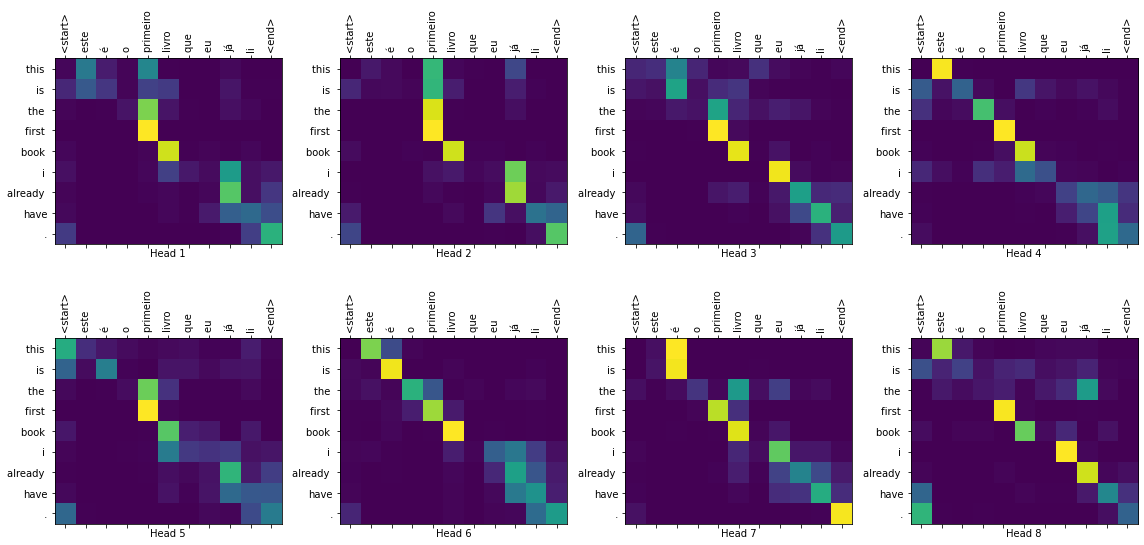

In [48]:
"""
eg: A B C D -> E F G H.    输入abcd 想的到efgh
Train: A B C D, E F G -> F G H
解读下：那么在训练的时候，为什么是 EFG ，因为就是那个tar-inp 一直到倒数第二个。希望可以预测FGH。在这个过程中，当看到abcd和e时候预测f
当看到abcdef时候预测g 当看到abcdefg时候预测h，因为在训练时候target是知道的，可以当作矩阵输入，也就是train-step里面的tar-inp
因为有look—ahead-mask保证前面的单词看不到后面的单词。

Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
解读：没有GT，就得单步。和seq2seq + attention 的思想是一样的。不同的是transformer可以并行化处理，处理encoder和decoder没前后计算的依赖
"""


def evaluate(inp_sentence):
    # 和构建数据集一样，将文本的句子转化成ID的句子
    inp_id_sentence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    # 由于transformer的输入是一个（batchsize，seq_len）的矩阵，所以需要对数据进行扩充维度
    # encoder_input.shape = (1,inp_id_sentence长度)
    encoder_input = tf.expand_dims(inp_id_sentence, axis = 0)
    # decoder_input 一开始只有一个ID，就是start id    shape = (1,1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], axis = 0)  # 以后每预测一个词就加到decoder_input上
    # 最后decoder_input的shape就成了decoder_output

    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
            = create_masks(encoder_input, decoder_input)
        # 此时这个decoder_input已经是那种看不到后面的单词的了，因为就是从零开始预测的，所以look_ahead_mask就没用了，但是为了统一起见，还是生成了
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)  output_target_len就是decoder_input当前长度
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # 这边当decoder_input长度为1就给出1个预测，为2就给出2个预测，为n就预测n个值   和seq + attention不一样，那个本身就是个单步的model
        # 那个就是每次只得到这一步的输出，而transformer 在decoder过程中是多步的预测，但是我想要的还是单步预测值，也就是最后一个，所以需要切片
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]  # 中间那个维度就是预测很多个值，但是我们只取最后一个值

        # 取出概率最大的索引  得到下一步的预测输入
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1), dtype = tf.int32)

        # 和seq + attention 一样 需要和end id 进行比较
        # 由于decoder_input是（1，target_len）  不需要第一个维度
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights

        decoder_input = tf.concat([decoder_input, [predicted_id]], axis = -1)  # 如果不是end 就拼接,加中括号是维度问题，predicted_id就是一个数

    return tf.squeeze(decoder_input, axis = 0), attention_weights


def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    # layer_name 指的是 attention weights 中的key 因为attention weights是一个字典，每个key就是字符串，value就是对应的attention权重
    # 其实就是encoder和decoder之间的key name
    fig = plt.figure(figsize = (16, 8))
    # 文本----->ID
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    # attention.shape: (batch_size,num_heads, tar_len, input_len)  可以看前面的多头注意力
    attention = tf.squeeze(attention[layer_name], axis = 0)  # (num_heads, tar_len, input_len)
    # 多个头，每个头都有一个attention的权重
    # print(attention)
    # print(attention.shape)
    for head in range(8):
        # print(type(head))
        ax = fig.add_subplot(2, 4, head + 1)  # 两行四列
        ax.matshow(attention[head][:-1, :]  , cmap = "viridis")  # 这边切片是因为，刚才在预测时候我把end id 给去除了，所以这边是在tar_len维度上取到倒数第二个
        font_dict = {'fontsize': 10}

        ax.set_xticks(range(len(input_id_sentence) + 2))  # +2 is start and end id
        ax.set_yticks(range(len(result)))  # 这两个函数接受的参数都是一个列表，所以 用range转化为列表

        ax.set_ylim(len(result) - 1.5, -0.5)  # 因为下面排除了start id 所以减去1.5
        # 设置每个锚点上对应的label
        ax.set_xticklabels(  # 取start和每个id对应词，用decode方法 还有 end  旋转
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = font_dict, rotation = 90)
        ax.set_yticklabels(  # 小于en_tokenizer.vocab_size的ID才转换，排除start和end
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = font_dict)
        ax.set_xlabel('Head {}'.format(head + 1))  # 第几个head

    plt.tight_layout()  # 自适应调整间距
    plt.show()


def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)  # result还只是ID

    predicted_sentence = en_tokenizer.decode(  # 不去decoder start 和end
        [i for i in result if i < en_tokenizer.vocab_size])

    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))

    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)


checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
translate('está muito frio aqui.')

translate('isto é minha vida')

translate('você ainda está em casa?')

translate('este é o primeiro livro que eu já li')

translate('este é o primeiro livro que eu já li',
          layer_name = 'decoder_layer4_att2')


Input: Podemos leer en una casa grande.
Predicted translation: i want to be asked to be big books .


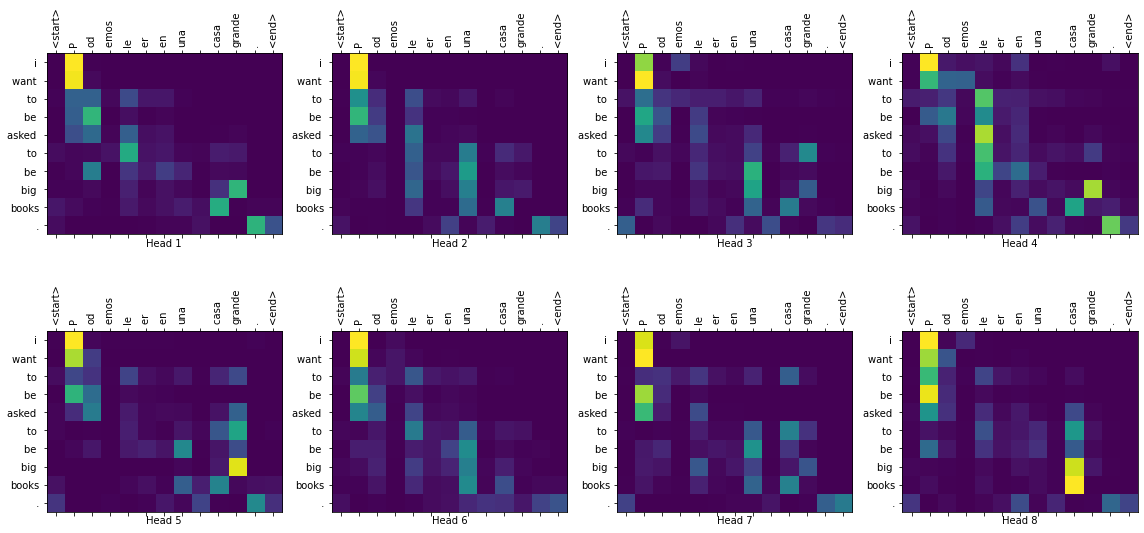

In [51]:
translate('Podemos leer en una casa grande.',
          layer_name = 'decoder_layer4_att2')
